# Summary

The term "life expectancy" refers to the number of years a person can expect to live. By definition, life expectancy is based on an estimate of the average age that members of a particular population group will be when they die. Things are often more complicated as the life expectancy depends on lifestyle, access to healthcare, diet, economical status and the relevant mortality data. You can think of life expectancy as the age a person born in a particular year would expect to live if the average age of death did not change over their lifetime.

Since the early 19th century, life expectancy started to increase globally and has more than doubled. However, this can be broken down further into "healthy life expectancy" and "years lived with disability". Understanding life expactancy of individuals living with disability can help better understand the group of people affected by the increase in life expectancy. Investigating the change in life expectancy broken down into smaller periods(few years) can reveal more information on what exactly led to this increase.

The dataset for this project was collected from [Our World in Data](https://ourworldindata.org/life-expectancy#how-has-healthy-life-expectancy-changed) and originates from the Institute of Health Metrics and Evaluation. The data I investigate here consists of records on "Healthy Life Expectancy" and "Years Lived With Disability" by countries and years(1990-2016) with no missing or ill-formatted entries.

# Exploring the data

An investigation of the dataset will determine the following:
 - number of rows and countries present
 - box plot for global healthy life expectancy and years lived with disability by year
 - bar plot for the global mean, min and max healthy life expectancy and years lived with disability by year

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("healthy-life-expectancy-and-years-lived-with-disability.csv")
# dropping column 'Code' as it's not useful for the analysis
data = data.drop('Code', axis = 1).rename(columns={'Entity':'Country', 'Healthy Life Expectancy (IHME)':'Healthy Life Expectancy','Years Lived With Disability (IHME)':'Years Lived With Disability'})
data.head()

,Country,Year,Healthy Life Expectancy,Years Lived With Disability
0,Afghanistan,1990,43.57,8.03
1,Afghanistan,1991,43.37,7.91
2,Afghanistan,1992,43.50,7.90
3,Afghanistan,1993,43.48,7.85
4,Afghanistan,1994,42.98,7.70


In [3]:
print('Number of rows: '+str(data.shape[0]))
print('Column names: '+str(data.columns.tolist()))
print('Number of countries: '+str(len(data['Country'].unique())))
print('Number of missing values: \n' + str(data.isnull().sum()))

Number of rows: 6102
Column names: ['Country', 'Year', 'Healthy Life Expectancy', 'Years Lived With Disability']
Number of countries: 226
Number of missing values: 
Country                        0
Year                           0
Healthy Life Expectancy        0
Years Lived With Disability    0
dtype: int64


[Text(0.5, 0, 'Year'), Text(0, 0.5, 'Healthy Life Expectancy in Years')]

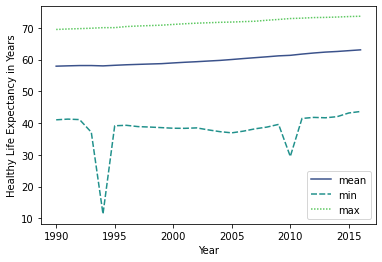

In [4]:
# groupping by years and taking the average/min/max gives the global mean/min/max for that year
df = data.groupby('Year')['Healthy Life Expectancy'].agg(['mean', 'min', 'max'])
ax = sns.lineplot(data=df, palette="viridis")
ax.set(xlabel='Year', ylabel='Healthy Life Expectancy in Years')

[Text(0.5, 0, 'Year'), Text(0, 0.5, 'Years Lived With Disability')]

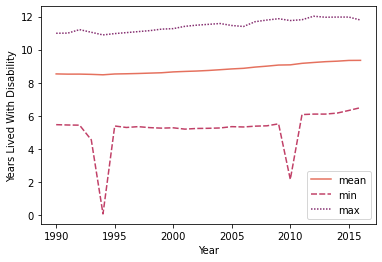

In [5]:
df2 = data.groupby('Year')['Years Lived With Disability'].agg(['mean', 'min', 'max'])
ax2 = sns.lineplot(data=df2, palette="flare")
ax2.set(xlabel='Year', ylabel='Years Lived With Disability')

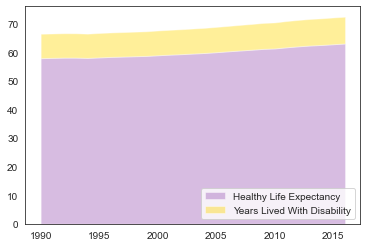

In [10]:
x=data['Year'].unique()
mean_hle = np.array(data.groupby('Year')['Healthy Life Expectancy'].agg(['mean'])).flatten()
mean_ylwd = np.array(data.groupby('Year')['Years Lived With Disability'].agg(['mean'])).flatten()
y=[ mean_hle, mean_ylwd ]

f = plt.figure(figsize=(6,4))
palette = sns.color_palette(["#9b59b6", "#ffd700"])
plt.stackplot(x, y, labels=['Healthy Life Expectancy', 'Years Lived With Disability'], colors=palette, alpha=0.4 )
plt.legend(loc='lower right')

[Text(0.5, 0, 'Year'), Text(0, 0.5, 'Years Lived With Disability')]

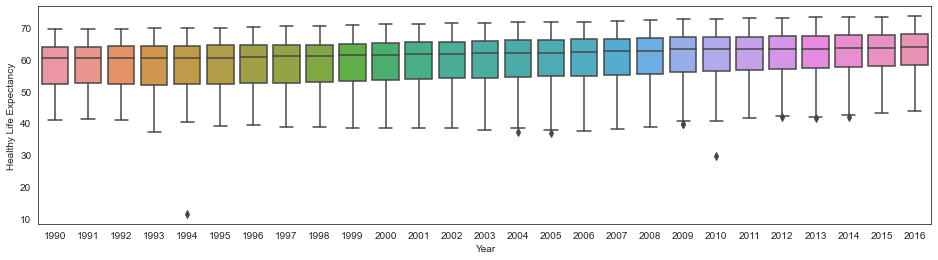

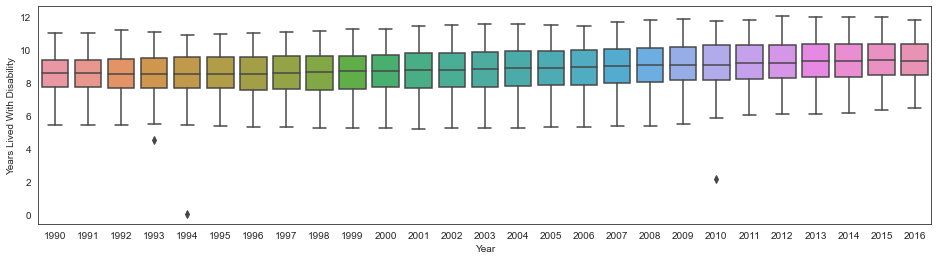

In [7]:
df_hle = data.groupby('Year')['Healthy Life Expectancy'].apply(lambda data: data.reset_index(drop=True)).unstack().T
df_ylwd = data.groupby('Year')['Years Lived With Disability'].apply(lambda data: data.reset_index(drop=True)).unstack().T

sns.set_style('white')
sns.set_palette('dark')

f = plt.figure(figsize=(16,4))
ax = sns.boxplot(data=df_hle);
ax.set(xlabel="Year", ylabel = "Healthy Life Expectancy")

f = plt.figure(figsize=(16,4))
ax2 = sns.boxplot(data=df_ylwd);
ax2.set(xlabel="Year", ylabel = "Years Lived With Disability")

# Featureset engineering and preparing the data
- deriving new feature 'Global Change' from previous and current years
- plot the global(=mean) change by year
- plot the change by year per country

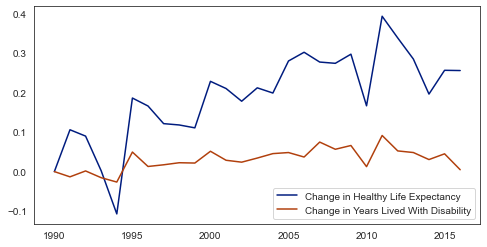

In [8]:
def has_previous(row, row_shift):
    if np.isnan(row_shift.all()):
        return '0'
    else:
        return row-row_shift
      
def add_global_change_feature(data, category):
    '''Derives new feature 'Change' from previous and current years '''
    
    # compute change from current and previous for each feature value
    change = data.apply(lambda x: has_previous(x, x.shift(1)))
    # first year has no previous year to be compared to
    change[category][1990] = 0
        
    # add to data as new feature
    data['Change ' + category] = change[category]
    
# global Healthy Life Expectancy groupped by year
hle_data = data.groupby('Year')['Healthy Life Expectancy'].agg(['mean'])
add_global_change_feature(hle_data, 'mean')
# global Years Lived With Disability groupped by year
ylwd_data = data.groupby('Year')['Years Lived With Disability'].agg(['mean'])
add_global_change_feature(ylwd_data, 'mean')

f = plt.figure(figsize=(8,4))
plt.plot(hle_data['Change mean'], label='Change in Healthy Life Expectancy')
plt.plot(ylwd_data['Change mean'], label='Change in Years Lived With Disability')
plt.legend(loc='lower right')

# Hypothesis testing

The above plot suggests that there is a continuous growth in both healthy life expectancy and years lived with disability.

**Hypothesis:** Assuming a the increase in life expectancy we are expecting the same growth in years lived with disability meaning that they have the same mean growth(global change).

**Alternative Hypothesis:** There is no relationship between the rate of increase in years lived with disability and healthy life expectancy.

Run a t-test comparing the global change in healthy life expectancy to years lived with disability. 

In [9]:
hle = np.array(hle_data.loc[2000:2005]['Change mean'])
ylwd = np.array(ylwd_data.loc[2006:2011]['Change mean'])
stats.ttest_ind(hle, ylwd, equal_var = False)

Ttest_indResult(statistic=8.869929709309053, pvalue=6.247525443440319e-06)

# Results
The p value is 6.247525443440319e-06 which is smaller than 0.05. Therefore we reject the null hypothesis at 5% significance level, meaning that the global growth in years lived with disability is not the same as in healthy life expectancy. On average the number of years in which people live with a given disability increased and in most cases it has been slower than the increase of healthy life expectancy.

# Next Steps

One of the most important inputs to health is healthcare. One common way of measuring national healthcare consumption and production is to estimate expenditure on healthcare. Research studies show that looking at the change over time countries with higher expenditure on healthcare per person tend to have a higher life expectancy.
Gathering data on the amount each country spends on healthcare can help better determine how the population is impacted by the improvements in healthcare.